In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [27]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt


In [28]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.gif')]

In [29]:
def convert_to_ela_image(image_mat):
    resaved_filename = 'hehehe' + '.resaved.jpg'
    ELA_filename = 'hehehe' + '.ela.png'
    
    im = Image.fromarray(np.uint8(image_mat * 255))
    im.save(resaved_filename, 'JPEG', quality=95)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
#     print ("Maximum difference was %d" % (max_diff))
    
#     print(array(ela_im).shape)
    return array(ela_im).reshape(128,128,3)

In [30]:
fakes_datasets_filename = get_imlist('datasets/train/fake/')
reals_datasets_filename = get_imlist('datasets/train/real/')

# Starts Here

In [31]:
def preprocess_input_ela(image):
    image = convert_to_ela_image(image)
    image = image / 255.0
    return(image)

In [32]:
image_size = 128

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input_ela,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

data_generator_no_aug = ImageDataGenerator(
                                    preprocessing_function=preprocess_input_ela
                                    )

train_generator = data_generator_with_aug.flow_from_directory(
        'datasets/train/',
        target_size=(image_size, image_size),
        batch_size=200,
        class_mode='categorical')

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input_ela)
validation_generator = data_generator_no_aug.flow_from_directory(
        'datasets/validation/',
        target_size=(image_size, image_size),
        batch_size=200,
        class_mode='categorical')

Found 13841 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model

In [33]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [34]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [35]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [37]:
epochs = 50
batch_size = 100

In [38]:
# Fit Model Here
history = model.fit_generator(
        train_generator,
        steps_per_epoch=23,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/50
22/23 [===========================>..] - ETA: 4s - loss: 6.1601 - acc: 0.5980

/home/agus/anaconda3/envs/cv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
/home/agus/anaconda3/envs/cv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))


StopIteration: cannot identify image file 'hehehe.resaved.jpg'

NameError: name 'history' is not defined

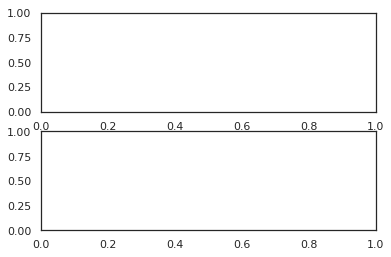

In [62]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

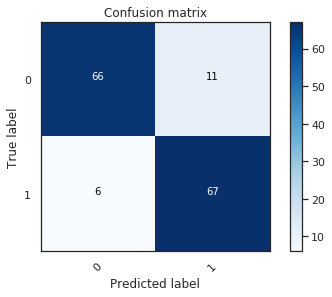

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))